In [1]:
import pandas as pd
import numpy as np
import re
import string
import nltk
import emoji
import matplotlib.pyplot as plt
import seaborn as sns
import torch

from bs4 import BeautifulSoup
from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Ensure NLTK resources are available
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Load dataset
file_path = "../Data/processed/Final_Noon_Datasets.csv"
df = pd.read_csv(file_path)



[nltk_data] Downloading package punkt to
[nltk_data]     /Users/hariharakumarrathinar/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/hariharakumarrathinar/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/hariharakumarrathinar/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


/var/folders/gx/9cn8k5x52gq_wpn2s2w4j2340000gn/T/ipykernel_76438/3146737197.py:6: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  return BeautifulSoup(text, "html.parser").get_text()
/var/folders/gx/9cn8k5x52gq_wpn2s2w4j2340000gn/T/ipykernel_76438/3146737197.py:6: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  return BeautifulSoup(text, "html.parser").get_text()


2025-02-25 01:24:25,664 Warning: An empty Sentence was created! Are there empty strings in your dataset?
2025-02-25 01:24:32,472 Warning: An empty Sentence was created! Are there empty strings in your dataset?
2025-02-25 01:24:48,188 Warning: An empty Sentence was created! Are there empty strings in your dataset?
2025-02-25 01:24:58,221 Warning: An empty Sentence was created! Are there empty strings in your dataset?


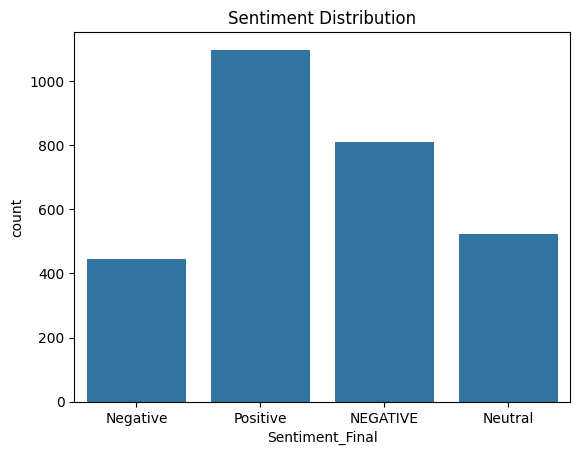

In [2]:
### Data Preprocessing ###
def to_lowercase(text):
    return text.lower()

def remove_html_tags(text):
    return BeautifulSoup(text, "html.parser").get_text()

def remove_urls(text):
    return re.sub(r'http\S+|www\S+', '', text)

def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))

def remove_special_chars(text):
    return re.sub(r'[^a-zA-Z0-9\s]', '', text)

def tokenize(text):
    return word_tokenize(text)

def remove_stopwords(tokens):
    stop_words = set(stopwords.words('english'))
    return [word for word in tokens if word not in stop_words]

def convert_emojis(text):
    return emoji.demojize(text, delimiters=(" ", " "))

def lemmatize(tokens):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(word) for word in tokens]

def preprocess_text(text):
    if not isinstance(text, str):
        return ""
    text = to_lowercase(text)
    text = remove_html_tags(text)
    text = remove_urls(text)
    text = convert_emojis(text)
    text = remove_punctuation(text)
    text = remove_special_chars(text)
    tokens = tokenize(text)
    tokens = remove_stopwords(tokens)
    tokens = lemmatize(tokens)
    return " ".join(tokens)

df['processed_comment'] = df['comment_text'].apply(preprocess_text)

# Train-Test Split
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

### Sentiment Analysis ###
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
import flair
from transformers import pipeline

# Initialize Sentiment Analyzers
vader_analyzer = SentimentIntensityAnalyzer()
flair_analyzer = flair.models.TextClassifier.load('en-sentiment')
classifier = pipeline("sentiment-analysis")

# Function to get sentiment using VADER
def get_vader_sentiment(text):
    score = vader_analyzer.polarity_scores(text)['compound']
    return "Negative" if score <= -0.05 else "Positive" if score >= 0.05 else "Neutral"

# Function to get sentiment using TextBlob
def get_textblob_sentiment(text):
    score = TextBlob(text).sentiment.polarity
    return "Positive" if score > 0 else "Negative" if score < 0 else "Neutral"

# Function to get sentiment using Flair
def get_flair_sentiment(text):
    sentence = flair.data.Sentence(text)
    flair_analyzer.predict(sentence)
    return sentence.labels[0].value if sentence.labels else "Neutral"

df_train['Sentiment_VADER'] = df_train['processed_comment'].apply(get_vader_sentiment)
df_train['Sentiment_TextBlob'] = df_train['processed_comment'].apply(get_textblob_sentiment)
df_train['Sentiment_Flair'] = df_train['processed_comment'].apply(get_flair_sentiment)

# Majority Voting for Final Sentiment Rating
def calculate_final_sentiment(row):
    sentiments = [row['Sentiment_VADER'], row['Sentiment_TextBlob'], row['Sentiment_Flair']]
    return max(set(sentiments), key=sentiments.count)

df_train['Sentiment_Final'] = df_train.apply(calculate_final_sentiment, axis=1)

# Visualize Sentiment Distribution
sns.countplot(x='Sentiment_Final', data=df_train)
plt.title("Sentiment Distribution")
plt.show()



Binary Representation Shape: (2878, 6952)
Frequency Representation Shape: (2878, 6952)
TF-IDF Representation Shape: (2878, 6952)
Naive Bayes: 0.4167


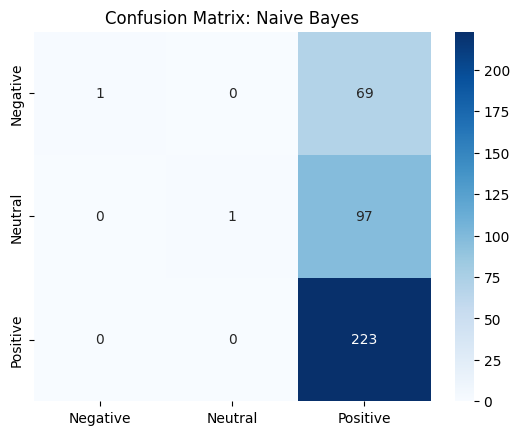

KNN: 0.1823


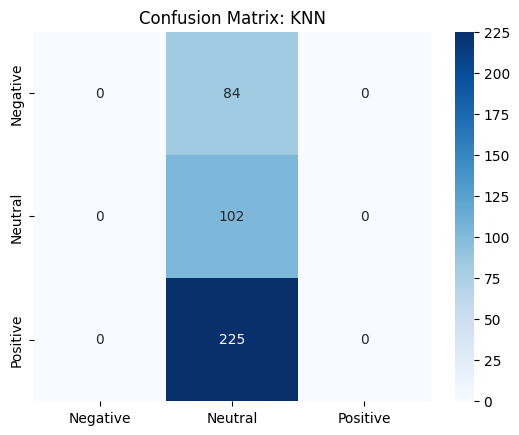

SVM: 0.6302


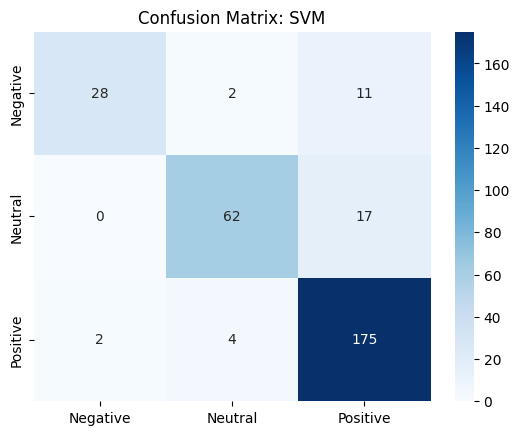

Logistic Regression: 0.6007


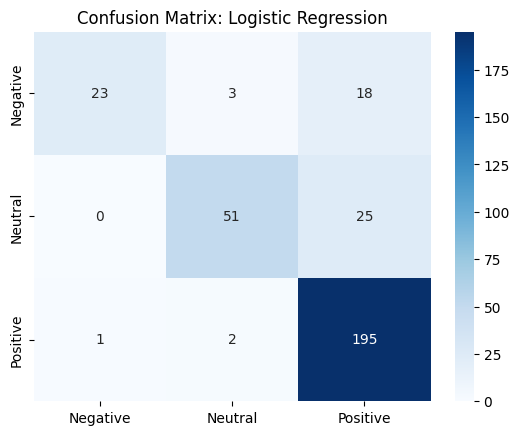

Neural Network: 0.5885


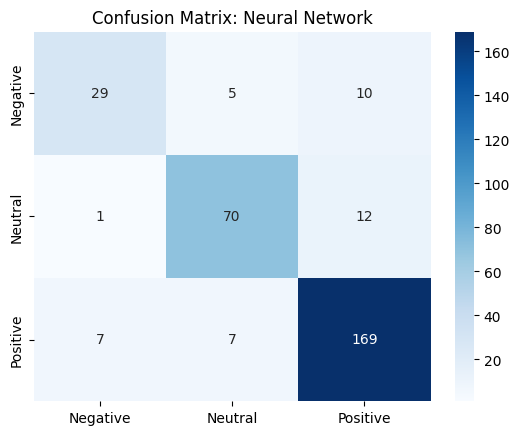

Best Model: SVM with Accuracy: 0.6302


In [4]:
### Vector Representation ###
vectorizers = {
    "Binary": CountVectorizer(binary=True),
    "Frequency": CountVectorizer(),
    "TF-IDF": TfidfVectorizer()
}

for name, vectorizer in vectorizers.items():
    X = vectorizer.fit_transform(df_train['processed_comment'])
    print(f"{name} Representation Shape: {X.shape}")

### Supervised Learning ###
models = {
    "Naive Bayes": MultinomialNB(),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "SVM": SVC(kernel='linear'),
    "Logistic Regression": LogisticRegression(),
    "Neural Network": MLPClassifier()
}

X_train, X_test, y_train, y_test = train_test_split(X, df_train['Sentiment_Final'], test_size=0.2, random_state=42)

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc
    print(f"{name}: {acc:.4f}")
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred, labels=["Negative", "Neutral", "Positive"])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Negative", "Neutral", "Positive"], yticklabels=["Negative", "Neutral", "Positive"])
    plt.title(f"Confusion Matrix: {name}")
    plt.show()

# Best Model Selection
best_model = max(results, key=results.get)
print(f"Best Model: {best_model} with Accuracy: {results[best_model]:.4f}")
